In [1]:
import sys
sys.path.append("src")
from qaoa.core.QAOA import QAOArunner
from  qaoa.models.MaxCutProblem import MaxCutProblem
import  qaoa.models.params as params
from rustworkx.visualization import mpl_draw as draw_graph
from old_jupyter_vizualisers.load_data import load_graph_from_csv
import numpy as np

In [8]:
import json
import sqlite3
import pandas as pd

# Connect to the SQLite database
conn = sqlite3.connect("qruns.db")
cursor = conn.cursor()

# Get list of tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print(f"Tables in the database: {tables}")

# Read data from the 'runs' table into a DataFrame
table = 'runs'
main_df = pd.read_sql(f"SELECT * FROM {table}", conn)

# Display information about the dataframe
print(f"Read dataframe with shape: {main_df.shape}")

# Close the database connection
# conn.close()  # Commented out to allow continued use of connection if needed
# Create a copy of the main dataframe
expanded_df = main_df.copy()

# Function to safely parse JSON
def parse_json(json_str):
    if pd.isna(json_str) or json_str is None:
        return {}
    try:
        return json.loads(json_str)
    except:
        return {}

# Parse artefact_path JSON strings
artefact_data = expanded_df['artefact_path'].apply(parse_json)

# Create a DataFrame from the parsed JSON
artefact_df = pd.json_normalize(artefact_data)

# Join the original DataFrame with the new columns
result_df = pd.concat([expanded_df, artefact_df], axis=1)

# Display the result
print(f"Expanded dataframe shape: {result_df.shape}")

# Also parse the params column if needed
params_data = expanded_df['params'].apply(parse_json)
params_df = pd.json_normalize(params_data)
full_result_df = pd.concat([result_df, params_df], axis=1)

# Save the expanded data
full_result_df.to_csv("expanded_runs.csv", index=False)

full_result_df

Tables in the database: [('runs',)]
Read dataframe with shape: (80, 8)
Expanded dataframe shape: (80, 37)


,id,params,state,node,started_at,finished_at,artefact_path,error_msg,graph_size,backend_mode,...,hamming_string.dtype,hamming_string.shape,graph_label,graph_path,backend_mode,qaoa_variant,param_initialization,depth,warm_start,problem_type
0,1,"{""graph_label"": ""paper1_0"", ""graph_path"": ""c:\...",done,NTNU24555,2025-05-13 11:41:15,2025-05-13 11:41:17,"{""graph_size"": 6, ""backend_mode"": ""statevector...",None,6,statevector,...,int64,[6],paper1_0,c:\Users\torbjsme\Master\QAOA\graphs_paper1\pa...,statevector,vanilla,gaussian,1,True,minvertexcover
1,2,"{""graph_label"": ""paper1_0"", ""graph_path"": ""c:\...",done,NTNU24555,2025-05-13 11:41:17,2025-05-13 11:41:18,"{""graph_size"": 6, ""backend_mode"": ""statevector...",None,6,statevector,...,int64,[6],paper1_0,c:\Users\torbjsme\Master\QAOA\graphs_paper1\pa...,statevector,vanilla,gaussian,1,True,minvertexcover
2,3,"{""graph_label"": ""paper1_0"", ""graph_path"": ""c:\...",done,NTNU24555,2025-05-13 11:41:17,2025-05-13 11:41:19,"{""graph_size"": 6, ""backend_mode"": ""statevector...",None,6,statevector,...,int64,[6],paper1_0,c:\Users\torbjsme\Master\QAOA\graphs_paper1\pa...,statevector,vanilla,gaussian,1,True,minvertexcover
3,4,"{""graph_label"": ""paper1_0"", ""graph_path"": ""c:\...",done,NTNU24555,2025-05-13 11:41:18,2025-05-13 11:41:19,"{""graph_size"": 6, ""backend_mode"": ""statevector...",None,6,statevector,...,int64,[6],paper1_0,c:\Users\torbjsme\Master\QAOA\graphs_paper1\pa...,statevector,vanilla,gaussian,1,True,minvertexcover
4,5,"{""graph_label"": ""paper1_0"", ""graph_path"": ""c:\...",done,NTNU24555,2025-05-13 11:41:18,2025-05-13 11:41:20,"{""graph_size"": 6, ""backend_mode"": ""statevector...",None,6,statevector,...,int64,[6],paper1_0,c:\Users\torbjsme\Master\QAOA\graphs_paper1\pa...,statevector,vanilla,gaussian,1,True,minvertexcover
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,76,"{""graph_label"": ""paper1_3"", ""graph_path"": ""c:\...",done,NTNU24555,2025-05-13 11:43:21,2025-05-13 11:43:39,"{""graph_size"": 9, ""backend_mode"": ""statevector...",None,9,statevector,...,int64,[9],paper1_3,c:\Users\torbjsme\Master\QAOA\graphs_paper1\pa...,statevector,vanilla,gaussian,2,True,minvertexcover
76,77,"{""graph_label"": ""paper1_3"", ""graph_path"": ""c:\...",done,NTNU24555,2025-05-13 11:43:21,2025-05-13 11:43:37,"{""graph_size"": 9, ""backend_mode"": ""statevector...",None,9,statevector,...,int64,[9],paper1_3,c:\Users\torbjsme\Master\QAOA\graphs_paper1\pa...,statevector,vanilla,gaussian,2,True,minvertexcover
77,78,"{""graph_label"": ""paper1_3"", ""graph_path"": ""c:\...",done,NTNU24555,2025-05-13 11:43:24,2025-05-13 11:43:40,"{""graph_size"": 9, ""backend_mode"": ""statevector...",None,9,statevector,...,int64,[9],paper1_3,c:\Users\torbjsme\Master\QAOA\graphs_paper1\pa...,statevector,vanilla,gaussian,2,True,minvertexcover
78,79,"{""graph_label"": ""paper1_3"", ""graph_path"": ""c:\...",done,NTNU24555,2025-05-13 11:43:25,2025-05-13 11:43:32,"{""graph_size"": 9, ""backend_mode"": ""statevector...",None,9,statevector,...,int64,[9],paper1_3,c:\Users\torbjsme\Master\QAOA\graphs_paper1\pa...,statevector,vanilla,gaussian,2,True,minvertexcover


In [1]:
import itertools

settings = {
'backend_mode' : ['statevector'], #nois_sampling
'qaoa_variant': ['vanilla','multiangle'],#,'multiangle'
'param_initialization': ['gaussian'],
'depth':[1,4],#MANGLER 10 PÅ MULTIANGLE
'warm_start': [True],
'problem_type': ['minvertexcover'],
'lagrangian_multiplier': [1,2,4,10],
'hamming_dist' : [1,3,5]
}

keys = settings.keys()
values = settings.values()

combinations = [dict(zip(keys, combination)) for combination in itertools.product(*values)]
print(f'echo "{combinations}" > qaoa_settings.txt')
#print(len(combinations))

echo "[{'backend_mode': 'statevector', 'qaoa_variant': 'vanilla', 'param_initialization': 'gaussian', 'depth': 1, 'warm_start': True, 'problem_type': 'minvertexcover', 'lagrangian_multiplier': 1, 'hamming_dist': 1}, {'backend_mode': 'statevector', 'qaoa_variant': 'vanilla', 'param_initialization': 'gaussian', 'depth': 1, 'warm_start': True, 'problem_type': 'minvertexcover', 'lagrangian_multiplier': 1, 'hamming_dist': 3}, {'backend_mode': 'statevector', 'qaoa_variant': 'vanilla', 'param_initialization': 'gaussian', 'depth': 1, 'warm_start': True, 'problem_type': 'minvertexcover', 'lagrangian_multiplier': 1, 'hamming_dist': 5}, {'backend_mode': 'statevector', 'qaoa_variant': 'vanilla', 'param_initialization': 'gaussian', 'depth': 1, 'warm_start': True, 'problem_type': 'minvertexcover', 'lagrangian_multiplier': 2, 'hamming_dist': 1}, {'backend_mode': 'statevector', 'qaoa_variant': 'vanilla', 'param_initialization': 'gaussian', 'depth': 1, 'warm_start': True, 'problem_type': 'minvertexcove

SparsePauliOp(['IIIIZI', 'IIIIIZ', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII', 'IIIIZZ', 'IIIZIZ', 'IIZIIZ', 'IZIIIZ', 'ZIIIIZ', 'IIZIZI', 'IZIIZI', 'ZIIIZI', 'IZIZII', 'ZIIZII'],
              coeffs=[1.61496939+0.j, 2.10128806+0.j, 1.02177962+0.j, 0.85263048+0.j,
 1.11605464+0.j, 1.02910093+0.j, 0.5       +0.j, 0.5       +0.j,
 0.5       +0.j, 0.5       +0.j, 0.5       +0.j, 0.5       +0.j,
 0.5       +0.j, 0.5       +0.j, 0.5       +0.j, 0.5       +0.j])
[1, 1, 1, 0, 1, 1]
None
4.2336147192800375
130
[3.06771263 1.56063235 4.13535723 1.74433961 2.96177043 1.6713641
 3.35853284 1.42804756 3.03626778 1.68993453 4.31113028 1.6452647
 3.39138195 2.97144024 3.59669131 1.67792211 2.60866154 1.6486712
 4.09779595 1.65732687]
m 0.0546875


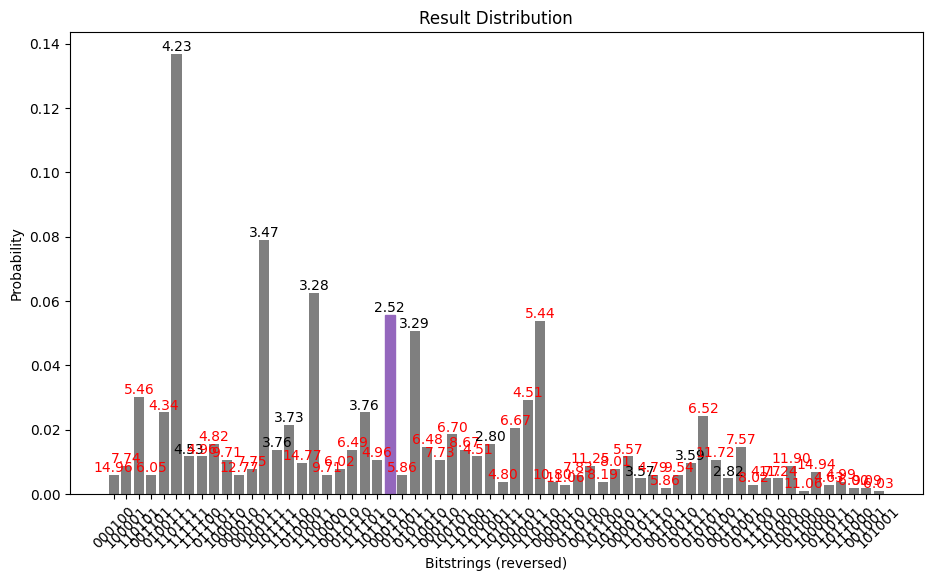

In [ ]:
graph = graphs[0]
quantum = QAOArunner(graph=graph, 
                     backend_mode = 'noisy_sampling',
                     param_initialization= 'gaussian',
                     qaoa_variant='vanilla',    
                     optimizer='COBYLA',
                     depth =10,
                     problem_type='minvertexcover',
                     warm_start=False,
                     amount_shots = 1000,
                     max_tol = 1e-2,#lower shots and tolerance for faster runs
                     hamming_dist = 2
                     )

quantum.build_circuit()
print(quantum.cost_hamiltonian)
quantum.run()
#print(f'Total time: {quantum.time_elapsed} in which {np.sum(quantum.runtimes)/quantum.time_elapsed:.2f}% was spent inside the cost_func_estimator and {1 - np.sum(quantum.runtimes)/quantum.time_elapsed:.2f} inside optimizer and help functions.')
#removed timer statements from qaoa so above line does not work
print(quantum.solution)
print(quantum.hamming_string)
print(quantum.evaluate_solution())
print(quantum.fev)
print(quantum.final_params)
print('m',quantum.get_prob_measure_optimal())
quantum.print_bitstrings()

In [6]:
print(quantum.circuit.count_ops())


OrderedDict([('sx', 157), ('rz', 134), ('cz', 82), ('measure', 6), ('barrier', 1)])


{'amount_shots': 1000,
 'backend': AerSimulator('aer_simulator_from(fake_marrakesh)'
             noise_model=<NoiseModel on ['measure', 'cz', 'x', 'id', 'sx', 'reset']>),
 'backend_mode': 'noisy_sampling',
 'circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x00000232CD183B20>,
 'classical_objective_func_vals': [],
 'classical_objective_value': 2.5239258519758856,
 'classical_solution': [1.0, 1.0, 1.0, 0, 0, 0],
 'cost_hamiltonian': SparsePauliOp(['IIIIZI', 'IIIIIZ', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII', 'IIIIZZ', 'IIIZIZ', 'IIZIIZ', 'IZIIIZ', 'ZIIIIZ', 'IIZIZI', 'IZIIZI', 'ZIIIZI', 'IZIZII', 'ZIIZII'],
              coeffs=[1.61496939+0.j, 2.10128806+0.j, 1.02177962+0.j, 0.85263048+0.j,
 1.11605464+0.j, 1.02910093+0.j, 0.5       +0.j, 0.5       +0.j,
 0.5       +0.j, 0.5       +0.j, 0.5       +0.j, 0.5       +0.j,
 0.5       +0.j, 0.5       +0.j, 0.5       +0.j, 0.5       +0.j]),
 'depth': 2,
 'fev': 39,
 'final_params': array([2.14487635, 1.42431168, 3.2803429 , 1.

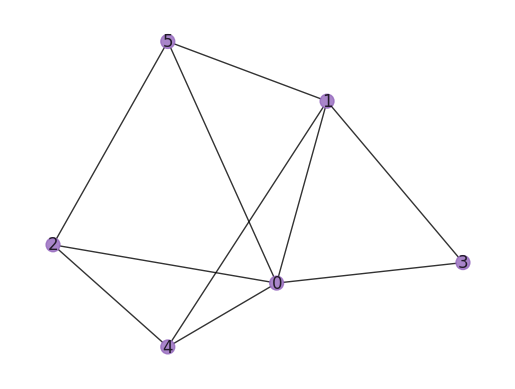

In [7]:
from pprint import pprint

pprint(quantum.__dict__)
quantum.plot_result()

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from qiskit_ibm_runtime import EstimatorV2 as Estimator
# Define the grid resolution
num_points = 100
gamma_vals = np.linspace(0, 4 * np.pi, num_points)
beta_vals = np.linspace(0,2* np.pi, num_points)
Gamma, Beta = np.meshgrid(gamma_vals, beta_vals)
Z = np.zeros_like(Gamma)



minvertexcover = False

quantum = QAOArunner(graph=graph, 
                     backend_mode='statevector',
                     param_initialization= 'gaussian',
                     qaoa_variant='vanilla', 
                     optimizer='COBYLA',
                     warm_start=False,
                     depth = 1,
                     vertexcover=minvertexcover,
                     amount_shots = 1000,
                     max_tol = 1e-8,
                     lagrangian_multiplier=2
                     )
quantum.build_circuit()
estimator = Estimator(mode=quantum.backend)
estimator.options.default_shots = 5000
# Evaluate cost function at each grid point



for i in tqdm(range(Gamma.shape[0]), desc="Evaluating energy landscape"):
    for j in range(Gamma.shape[1]):
        params = np.array([Gamma[i, j], Beta[i, j]])  # Format your params as needed
        Z[i, j] = quantum.cost_func_estimator(params, quantum.circuit, quantum.cost_hamiltonian,estimator)

# Plot the energy landscape
plt.figure(figsize=(8, 6))
cp = plt.contourf(Gamma, Beta, Z, levels=50)
plt.colorbar(cp, label='Energy')
plt.title("Energy Landscape over [γ, β]")
plt.xlabel("Gamma (γ)")
plt.ylabel("Beta (β)")
plt.show()


TypeError: QAOArunner.__init__() got an unexpected keyword argument 'vertexcover'

In [ ]:
import pandas as pd

# Save Z as a CSV file
df_z = pd.DataFrame({'x': Gamma.ravel(), 'y': Beta.ravel(), 'z': Z.ravel()})
df_z.columns = ['x', 'y', 'z']
df_z.to_csv('percentage_measure_optimal_erdos_renyi_5_2_MaxCut.csv', index=False)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

strin = 'MinVertexCover' if minvertexcover else 'MaxCut'

import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(z=Z, x=Gamma, y=Beta, colorscale='Viridis')])
fig.update_layout(
    title=f"Percent chance of sampling optimal solution given [γ, β] for Erdos Renyi graph size 5, high prob of edges, for {strin}",
    scene=dict(
        xaxis_title="Gamma (γ)",
        yaxis_title="Beta (β)",
        zaxis_title="Energy"
    )
)
fig.show()

